#### Binary classification on raw dBN sequences

In [71]:
import pandas as pd
import os
import random 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from classification_utils import fill_NaN
import torch
from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam

s = 2
random.seed(s)
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed_all(s)

In [72]:
# PATHS
event_path = 'labelled_data/event/'
non_event_path = 'labelled_data/non-events/'

In [73]:
sequences_ev, sequences_non_ev = [], []

filling_method = 'linear_interpolation'

for e in os.listdir(event_path):
    # get event sequence
    df = pd.read_csv(event_path+e)
    seq = df.sort_values(by=['Date_UTC' if 'Date_UTC' in df.columns else 'Unnamed: 0']).dbn_nez

    # fill NaN
    seq_filled = fill_NaN(seq, filling_method)
    
    # add data to sequences and labels
    sequences_ev.append(np.array(seq_filled))


for e in os.listdir(non_event_path):
    # get non-event sequence
    df = pd.read_csv(non_event_path+e)
    seq = df.sort_values(by=['Date_UTC' if 'Date_UTC' in df.columns else 'Unnamed: 0']).dbn_nez

    # fill NaN
    seq_filled = fill_NaN(seq, filling_method)

    # update sequences and labels
    sequences_non_ev.append(np.array(seq_filled))


In [74]:
len(sequences_non_ev), len(sequences_ev)

(4595, 193)

#### Unbalanced classes: way more non-events
##### Random under-sampling of non-events

In [75]:
lab_dict = {'event':1, 'non-event':0}

sample_n = len(os.listdir(event_path))
random_non_ev = random.sample(sequences_non_ev, sample_n)

In [76]:
sequences = random_non_ev + sequences_ev
labels = len(random_non_ev) * [lab_dict['non-event']] + len(sequences_ev) * [lab_dict['event']]
sequences, labels = np.array(sequences), np.array(labels)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.3, shuffle=True, random_state=s)

In [78]:
Counter(y_test), Counter(y_train)

(Counter({0: 59, 1: 57}), Counter({1: 136, 0: 134}))

#### Logistic regression with input original signals

In [79]:
# array to torch tensor
X_train, X_test, y_train, y_test = torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test)

In [80]:
# standardize data using training mean and variance
mu_train = X_train.mean(dim=0)
std_train = X_train.std(dim=0)

Sx_train = (X_train - mu_train) / std_train
Sx_test = (X_test - mu_train) / std_train

In [81]:
Sx_train = Sx_train.float()
Sx_test = Sx_test.float()

In [82]:
num_input = Sx_train.shape[-1]
num_classes = y_train.unique().numel()

# fully connected linear layer + log softmax
model = Sequential(Linear(num_input, num_classes), LogSoftmax(dim=1))
optimizer = Adam(model.parameters())
criterion = NLLLoss() # negative log likelihood loss

batch_size = 32 # number of signals to use in each gradient descent step
num_epochs = 50
lr = 1e-4

# total num of batches
n_samples = Sx_train.shape[0]
n_batches = n_samples // batch_size

for e in range(num_epochs):
    # random permutation
    perm = torch.randperm(n_samples)

    # for each batch, compute gradient wrt loss
    for i in range(n_batches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        model.zero_grad()
        resp = model.forward(Sx_train[idx])
        loss = criterion(resp, y_train[idx])
        loss.backward()
        # take one step
        optimizer.step()

    
    resp = model.forward(Sx_train)
    avg_loss = criterion(resp, y_train)

    # predict training set classes to compute accuracy while training
    y_hat = resp.argmax(dim=1)
    accuracy = (y_train == y_hat).float().mean()

    print('Epoch {}, average loss = {:1.3f}, accuracy = {:1.3f}'.format(e, avg_loss, accuracy))

Epoch 0, average loss = 0.698, accuracy = 0.548
Epoch 1, average loss = 0.685, accuracy = 0.681
Epoch 2, average loss = 0.793, accuracy = 0.607
Epoch 3, average loss = 0.683, accuracy = 0.593
Epoch 4, average loss = 0.666, accuracy = 0.644
Epoch 5, average loss = 0.663, accuracy = 0.689
Epoch 6, average loss = 0.668, accuracy = 0.644
Epoch 7, average loss = 0.647, accuracy = 0.696
Epoch 8, average loss = 0.650, accuracy = 0.693
Epoch 9, average loss = 0.658, accuracy = 0.756
Epoch 10, average loss = 0.668, accuracy = 0.659
Epoch 11, average loss = 0.647, accuracy = 0.681
Epoch 12, average loss = 0.658, accuracy = 0.656
Epoch 13, average loss = 0.649, accuracy = 0.693
Epoch 14, average loss = 0.648, accuracy = 0.696
Epoch 15, average loss = 0.642, accuracy = 0.730
Epoch 16, average loss = 0.639, accuracy = 0.700
Epoch 17, average loss = 0.635, accuracy = 0.715
Epoch 18, average loss = 0.655, accuracy = 0.741
Epoch 19, average loss = 0.645, accuracy = 0.685
Epoch 20, average loss = 0.686

In [83]:
resp = model.forward(Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('TESTING: neg. ll loss = {:1.3f}, accuracy = {:1.3f}'.format(avg_loss, acc))

TESTING: neg. ll loss = 0.710, accuracy = 0.655


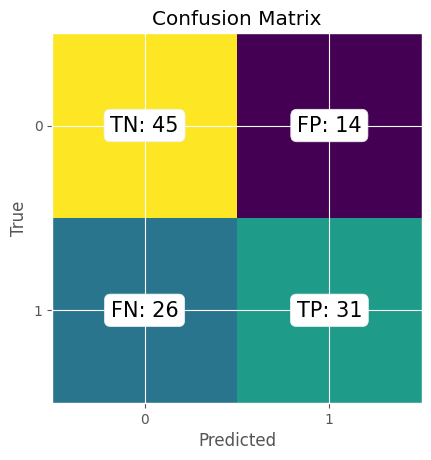

In [84]:
# confusion matrix

preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

plt.figure()
plt.imshow(confusion, cmap='viridis') 

tick_locs = np.arange(2)
ticks = ['{}'.format(i) for i in range(0, 2)]

plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)

plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(2):
    for j in range(2):

        if i == 0 and j == 0:
            lab = 'TN: '
        elif i == 0 and j == 1:
            lab = 'FP: '
        elif i == 1 and j == 0:
            lab = 'FN: '
        else:
            lab = 'TP: '


        plt.text(j, i, lab+str(confusion[i, j]), ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle="round", fc="w"))

plt.title('Confusion Matrix')
plt.show()

In [85]:
# apply your trained model to test data to get probability estimates for each class 
model.eval() 
with torch.no_grad():
    logits = model(Sx_test)
    probs = torch.softmax(logits, dim=1)  # softmax to convert the model's output into probabilities


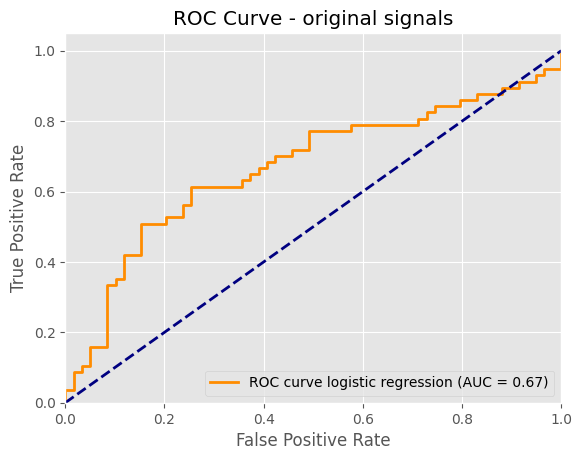

In [86]:
# ROC
fpr, tpr, thresholds = roc_curve(true_test, probs[:, 1].numpy())

# AUC
roc_auc = roc_auc_score(true_test, probs[:, 1].numpy())


# plot ROC  
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve logistic regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - original signals')
plt.legend(loc='lower right')
plt.show()


In [87]:
precision_log_reg, recall_log_reg, f1_score_log_reg, support_log_reg = precision_recall_fscore_support(true_test, preds_test)
acc_log_reg = accuracy_score(true_test, preds_test)

#### Random Forest

In [88]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.3, shuffle=True, random_state=s)

# standardize data using training mean and variance
mu_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)

X_train = (X_train - mu_train) / std_train
X_test = (X_test - mu_train) / std_train

In [89]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.8448275862068966

In [90]:
probs_rf = classifier.predict_proba(X_test)

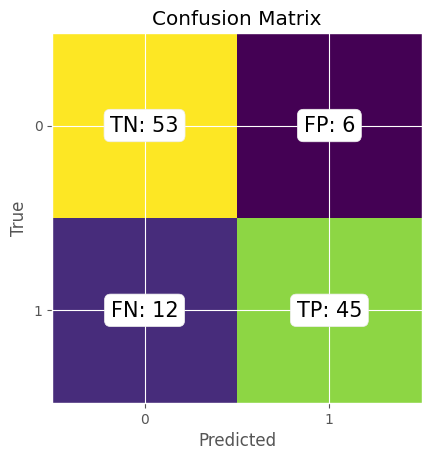

In [91]:
confusion = confusion_matrix(y_test, y_pred)

from classification_utils import plot_confusion_matrix, plot_ROC_AUC
plot_confusion_matrix(confusion)

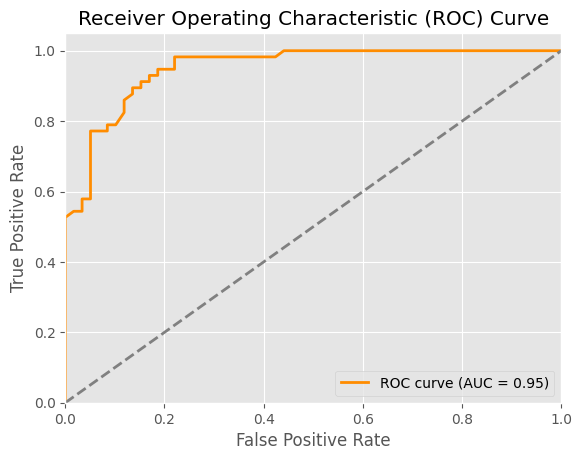

In [92]:
# ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_rf[:, 1])
# AUC
roc_auc_rf = roc_auc_score(y_test, probs_rf[:, 1])

plot_ROC_AUC(fpr_rf, tpr_rf, roc_auc_rf)

In [93]:
precision_rf, recall_rf, f1_score_rf, support_rf = precision_recall_fscore_support(y_test, y_pred)
acc_rf = accuracy_score(y_test, y_pred)

_______

#### SVC

In [94]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, GridSearchCV

In [95]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.3, shuffle=True, random_state=s)

# standardize data using training mean and variance
mu_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)

X_train = (X_train - mu_train) / std_train
X_test = (X_test - mu_train) / std_train

In [96]:
param_grid = { 
        'C': [ 0.1,  1. , 2., 10. ], # regularization
        'class_weight':[{0:1, 1:2.2, 2:1},
                        {0:1, # class : weight
                         1:2, # give weight 2 to class 1 (SI event), and weight 1 to the other two, since SI are the most misclassified
                         2:1},  
                        {0:1, 1:1.5, 2:1.2},
                        {0:1, 1:2, 2:1.5}
                        ],
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'] # kernel coefficent for poly, rbf, sigmoid
        }


# 10 folds CV
n_splits, n_repeats = 10, 5
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=s)
grid_search = GridSearchCV(estimator=SVC(), 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            refit='accuracy', 
                            n_jobs=-1, 
                            cv=cv)
gridCV = grid_search.fit(X_train, y_train)
gridCV.best_params_

{'C': 10.0,
 'class_weight': {0: 1, 1: 2.2, 2: 1},
 'gamma': 'scale',
 'kernel': 'rbf'}

In [97]:
# best model
svc = SVC(**gridCV.best_params_, probability=True).fit(X_train, y_train)
# predict
svm_preds = svc.predict(X_test)
confusion = confusion_matrix(y_test, svm_preds)

# probabilities
svc_probs = svc.predict_proba(X_test)


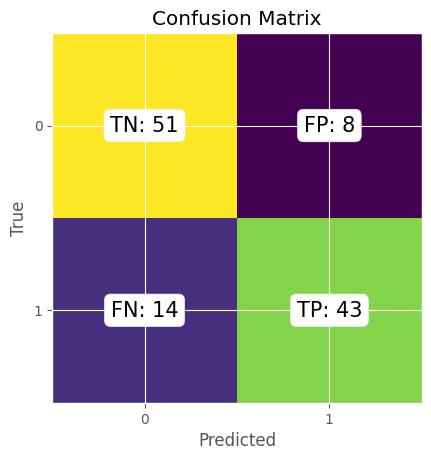

In [98]:
plot_confusion_matrix(confusion)

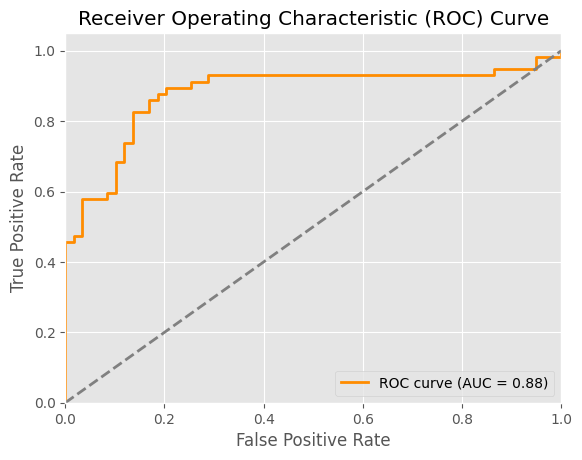

In [99]:
# ROC
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, svc_probs[:, 1])
# AUC
roc_auc_svc = roc_auc_score(y_test, svc_probs[:, 1])

plot_ROC_AUC(fpr_svc, tpr_svc, roc_auc_svc)

In [100]:
precision_svc, recall_svc, f1_score_svc, support_svc = precision_recall_fscore_support(y_test, svm_preds)
acc_svc = accuracy_score(y_test, svm_preds)

_________

#### Compare models ROC

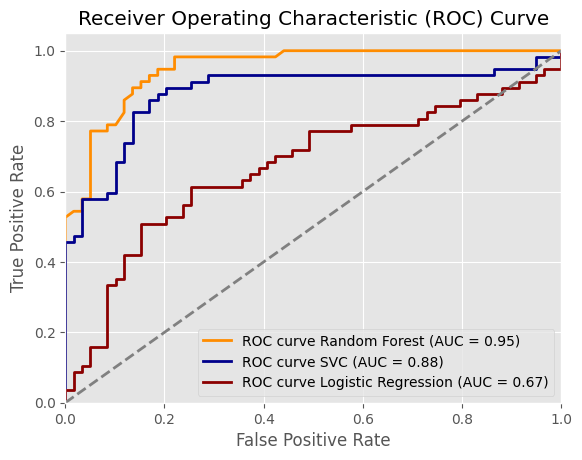

In [101]:
# plot ROC curve
plt.figure()

# Random Forest
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve Random Forest (AUC = {roc_auc_rf:.2f})') 

# SVC
plt.plot(fpr_svc, tpr_svc, color='darkblue', lw=2, label=f'ROC curve SVC (AUC = {roc_auc_svc:.2f})')

# logistic regression 
plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve Logistic Regression (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [102]:
result_report = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Logistic Regression': [precision_log_reg.mean(), recall_log_reg.mean(), f1_score_log_reg.mean(), acc_log_reg],
    'SVC ': [precision_svc.mean(), recall_svc.mean(), f1_score_svc.mean(), acc_svc],
    'Random Forest': [precision_rf.mean(), recall_rf.mean(), f1_score_rf.mean(), acc_rf]
}

result_report_df = pd.DataFrame(result_report)

result_report_df.style.background_gradient(cmap = sns.light_palette("green", as_cmap=True))

,Metric,Logistic Regression,SVC,Random Forest
0,Precision,0.661346,0.813876,0.848869
1,Recall,0.653286,0.809396,0.843889
2,F1-Score,0.650075,0.809438,0.844086
3,Accuracy,0.655172,0.810345,0.844828


In [103]:
result_report = {
    'Metric Type': ['Precision', '', 'Recall', '', 'F1-Score', '' ],
    'Metric': ['Non-Event (0)', 'Event (1)',  'Non-Event (0)', 'Event (1)', 'Non-Event (0)', 'Event (1)', ],
    'Logistic Regression': np.concatenate((precision_log_reg, recall_log_reg, f1_score_log_reg)),
    'SVC (Full)': np.concatenate((precision_svc, recall_svc, f1_score_svc)),
    'Random Forest (Full)': np.concatenate((precision_rf, recall_rf, f1_score_rf))
}

result_report_df = pd.DataFrame(result_report)

result_report_df.set_index('Metric Type')

,Metric,Logistic Regression,SVC (Full),Random Forest (Full)
Metric Type,,,,
Precision,Non-Event (0),0.633803,0.784615,0.815385
,Event (1),0.688889,0.843137,0.882353
Recall,Non-Event (0),0.762712,0.864407,0.898305
,Event (1),0.543860,0.754386,0.789474
F1-Score,Non-Event (0),0.692308,0.822581,0.854839
,Event (1),0.607843,0.796296,0.833333


In [104]:
result_report_df.style.background_gradient(cmap = sns.light_palette("green", as_cmap=True))

,Metric Type,Metric,Logistic Regression,SVC (Full),Random Forest (Full)
0,Precision,Non-Event (0),0.633803,0.784615,0.815385
1,,Event (1),0.688889,0.843137,0.882353
2,Recall,Non-Event (0),0.762712,0.864407,0.898305
3,,Event (1),0.543860,0.754386,0.789474
4,F1-Score,Non-Event (0),0.692308,0.822581,0.854839
5,,Event (1),0.607843,0.796296,0.833333
